Attempt to select a better set of active poses from our DUDe training set by applying a genetic algorithm to maximize the cross-validation performance of linear regression.

1. Read massive DUDe file (16GB), save all actives, create 10(?) random sampeles of balanced decoys.  This means if there are ~20,000 distinct active ligands, we will have 10 different sets of randomly selected 20,000 decoys, but with no more than one pose per ligand.
2. Segment training set into 3 folds, leaving target collections intact.
3. Represent a population as a selection of each pose of the active ligands.  Initialize with the best scoring pose.  Note selection spans training and test sets.
3. Evaluate fitness by cross-validation of linear regression.
4. Mutation randomly selects different pose. Crossover randomly chooses between two populations.

In [661]:
import numpy as np
import sys, re, math,scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy import interp
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
#load in entire SCOREDATA
activedata = dict() #indexed by target and then by ligand
decoydata = dict() #indexed by target and then by ligand

for (i,line) in enumerate(open('/home/dkoes/scorebench/DUDe/SCOREDATA')):
    tokens = line.rstrip().split()
    target = tokens[1]
    ligname = tokens[3]
    y = int(tokens[0])
    x = np.array(tokens[4:],np.float32)
    if len(x) != 61:
        continue
    if 'vina' not in tokens[2]:
        continue
    if i % 1000000 == 0: sys.stdout.write('%d\n' % (i / 1000000))
    if i % 10000 == 0: sys.stdout.write('.')
    #select correct dictionary
    if y > 0: #active
        scoredata = activedata
    else:
        scoredata = decoydata
    
    #add to dictionary
    if target not in scoredata:
        scoredata[target] = dict()
    if ligname not in scoredata[target]:
        scoredata[target][ligname] = []
        
    scoredata[target][ligname].append(x) 

........................................................................................................2
.................................................3
..................................................4
..............................................................................................................................................7
................................................8
........................................................9
........................................................................................................11
............................................................................................13
..................................................14
........................................15
.................................................16
.................................................17
..................................................18
....................................................................................

In [169]:
#make a three fold partitioning
FOLDS = 3
#create list of target,cnt pairs
targetcnts = []
for target in decoydata.keys():
    numactives = len(activedata[target].keys())
    targetcnts.append((target,numactives))
targetcnts.sort(key=lambda (targ,cnt): cnt, reverse=True)

#create balanced folds
foldcnts = np.zeros(FOLDS)
folds = [[] for _ in xrange(FOLDS)]
for target,cnt in targetcnts:
    i = np.argmin(foldcnts)
    foldcnts[i] += cnt
    folds[i].append(target)

In [351]:
#for each target create random decoy samples the same size as the actives
#folddecoysamples is indexed first by sample index, then by fold
K = 5 #number of decoy samples
folddecoysamples = []
for i in xrange(K):
    folddecoysamples.append([]) #index first by sample index
    for fold in folds:
        foldsamples = []
        for target in fold:
            numactives = len(activedata[target].keys())
            decoynames = decoydata[target].keys()
            np.random.shuffle(decoynames);
            for n in decoynames[:numactives]:
                poses = sorted(decoydata[target][n],key=lambda x: x[0])
                if i == 0: #first sampel always best scoring
                    x = poses[0]
                else: 
                    x = poses[np.random.randint(len(poses))]
                foldsamples.append(x)
        folddecoysamples[i].append(np.array(foldsamples)) #second index is fold

In [352]:
#now restructure actives into folds that are consistently indexed
foldactives = [] #index first by fold, then by ligand index, which returns list of poses sorted by vina
for fold in folds:
    acts = []
    for target in fold:
        anames = sorted(activedata[target].keys())
        for n in anames:
            poses = sorted(activedata[target][n],key=lambda vals: vals[0])
            acts.append(poses)
    foldactives.append(acts)

In [353]:
aposecnts = [len(poses) for f in foldactives for poses in f]

In [354]:
init_population = [ np.zeros(len(f),np.int) for f in foldactives ]

In [359]:
def applyposeselect(poseselect, active):
    '''return single list of active examples '''
    res = []
    for (pose,aposes) in zip(poseselect,active):
        res.append(aposes[pose])
    return res
    
def makepred(traindecoys, trainactives, testdecoys, testactives):
    '''return labeled predictions of test set'''
    x = np.array(traindecoys + trainactives)
    y = [0 for _ in xrange(len(traindecoys))] + [1 for _ in xrange(len(trainactives))]
    classifier = LinearRegression()
    classifier.fit(x, y)
    
    tx = np.concatenate((testdecoys,testactives))
    ty = [0 for _ in xrange(len(testdecoys))] + [1 for _ in xrange(len(testactives))]
    pred = classifier.predict(tx)
    return (ty,list(pred))

def evalpop(pop):
    '''evaluate selection of active poses for cross-validation accuracy'''
    activefolds = []
    for (poses, actives) in zip(pop, foldactives):
        activefolds.append(applyposeselect(poses, actives))
    
    aucs = []
    for dsample in folddecoysamples:
        labels = []
        predictions = []
        for i in xrange(len(activefolds)): #for each fold
            testactives = activefolds[i]
            testdecoys = dsample[i]
            trainactives = activefolds[:i] + activefolds[i+1:]
            traindecoys = dsample[:i] + dsample[i+1:]
            #flatten
            traindecoys = [item for sublist in traindecoys for item in sublist]
            trainactives = [item for sublist in trainactives for item in sublist]
    
            (lab,pred) = makepred(traindecoys,trainactives,testdecoys,testactives)
            labels += lab
            predictions += pred
            
        #evaluate overall auc
        auc = roc_auc_score(labels,predictions)
        print auc
        aucs.append(auc)
    
    #return average auc
    return np.mean(aucs)

def evalvinapop(pop):
    '''return auc of vina score'''
    activefolds = []
    for (poses, actives) in zip(pop, foldactives):
        activefolds.append(applyposeselect(poses, actives))
    
    aucs = []
    for dsample in folddecoysamples:
        labels = []
        predictions = []
        for i in xrange(len(activefolds)): #for each fold
            testactives = activefolds[i]
            testdecoys = dsample[i]

            lab = [0 for _ in xrange(len(testdecoys))] + [1 for _ in xrange(len(testactives))]
            pred = list(-np.array(testdecoys)[:,0]) + list(-np.array(testactives)[:,0])
            labels += lab
            predictions += pred
            
        #evaluate overall auc
        auc = roc_auc_score(labels,predictions)
        aucs.append(auc)
    
    #return average auc
    return np.mean(aucs)

In [360]:
bad_population = []
for f in foldactives:
    bad = []
    for ex in f:
        bad.append(len(ex)-1)
    bad_population.append(bad)
    
rand_population = []
for f in foldactives:
    bad = []
    for ex in f:
        bad.append(np.random.randint(len(ex)))
    rand_population.append(bad)    

In [361]:
evalvinapop(init_population),evalpop(init_population)

0.767367884726
0.860490081802
0.85864129797
0.858570599294
0.859963658065


(0.78308814094259016, 0.84100670437139213)

In [362]:
evalvinapop(bad_population),evalpop(bad_population)

0.778115365656
0.691330043949
0.68835109925
0.687454504937
0.688060931245


(0.49430761383144495, 0.70666238900740308)

In [363]:
evalvinapop(rand_population),evalpop(rand_population)

0.698030663362
0.725979970301
0.72255186553
0.721897492283
0.723506320081


(0.62874592465883494, 0.71839326231126699)

* create model from a population
* evaluate on D3R
* GA
* figure out important features (weights time abs value), backward selection


In [364]:
dec = np.concatenate(folddecoysamples[0])

In [365]:
#read csar
csarlabels = []
csarfeatures = []
balcsarlabels = []
balcsarfeatures = []
bal = dict()
for line in open("/home/dkoes/scorebench/CSAR/SCOREDATA.csar.train.active"):
    tokens = line.rstrip().split()
    target = tokens[1]
    ligname = tokens[3]
    y = 1
    x = np.array(tokens[4:],np.float32)
    csarlabels.append(y)
    csarfeatures.append(x)
    if target not in bal:
        bal[target] = []
    bal[target].append((float(tokens[0]),x))
    
#for balancedactives pick single closest
for target in bal:
    s = sorted(bal[target],key=lambda (r,vals): r)
    balcsarlabels.append(1)
    balcsarfeatures.append(s[0][1])
    
bal = dict()

for line in open("/home/dkoes/scorebench/CSAR/SCOREDATA.csar.train.decoy"):
    tokens = line.rstrip().split()
    target = tokens[1]
    ligname = tokens[3]
    y = 0
    x = np.array(tokens[4:],np.float32)
    csarlabels.append(y)
    csarfeatures.append(x)    
    if target not in bal:
        bal[target] = []
    bal[target].append((x[0],x))
    
#for balancedactives pick best score
for target in bal:
    s = sorted(bal[target],key=lambda (r,vals): r)
    balcsarlabels.append(0)
    balcsarfeatures.append(s[0][1])
    
csarfeatures = np.array(csarfeatures)
balcsarfeatures = np.array(balcsarfeatures)

In [366]:
activefolds = []
for (poses, actives) in zip(bad_population, foldactives):
        activefolds += applyposeselect(poses, actives)
act = np.array(activefolds)

In [367]:
act[:,0]

array([-10.5039053 ,  -8.51364326,  -7.59002161, ...,  -9.02105904,
        -5.44132662,  -5.25003386], dtype=float32)

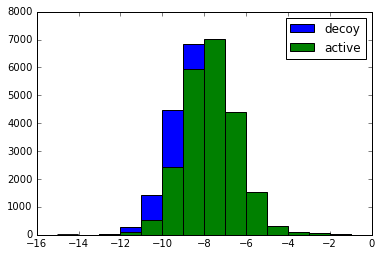

In [368]:
plt.hist(dec[:,0],bins=np.arange(-15,0),label="decoy")
plt.hist(act[:,0],bins=np.arange(-15,0),label="active")
plt.legend()

In [369]:
def makemodel(pop):
    '''return a classifier trained using the actives specified by pop and the first decoy set'''
    activefolds = []
    for (poses, actives) in zip(pop, foldactives):
        activefolds.append(applyposeselect(poses, actives))
    trainactives = activefolds
    traindecoys = folddecoysamples[0]
    traindecoys = [item for sublist in traindecoys for item in sublist]
    trainactives = [item for sublist in trainactives for item in sublist]
    x = np.array(traindecoys + trainactives)
    y = [0 for _ in xrange(len(traindecoys))] + [1 for _ in xrange(len(trainactives))]
    classifier = LinearRegression()
    classifier.fit(x, y)
    return classifier

In [370]:
model_init = makemodel(init_population)
model_bad = makemodel(bad_population)

In [371]:
pi = model_init.predict(csarfeatures)
pib = model_init.predict(balcsarfeatures)
roc_auc_score(balcsarlabels,pib),roc_auc_score(csarlabels,pi)

(0.66086822660098521, 0.6569367747917263)

In [372]:
p = model_bad.predict(csarfeatures)
pb = model_bad.predict(balcsarfeatures)

roc_auc_score(balcsarlabels,pb),roc_auc_score(csarlabels,p)

(0.39822796934865901, 0.32385227907991437)

In [373]:
roc_auc_score(csarlabels,-csarfeatures[:,0]),roc_auc_score(balcsarlabels,-balcsarfeatures[:,0])

(0.60855012885016568, 0.6170977011494253)

In [374]:
vinafpr, vinatpr, threshold = roc_curve(csarlabels,-csarfeatures[:,0])
ifpr, itpr, _ = roc_curve(csarlabels,pi)
bifpr, bitpr, _ = roc_curve(balcsarlabels,pib)

bfpr, btpr, _ = roc_curve(csarlabels,p)

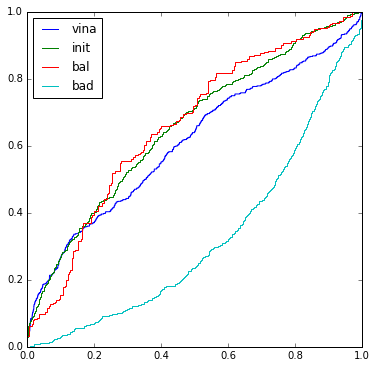

In [375]:
plt.figure(figsize=(6,6))
plt.plot(vinafpr,vinatpr,label="vina")
plt.plot(ifpr,itpr,label="init")
plt.plot(bifpr,bitpr,label="bal")
plt.plot(bfpr,btpr,label="bad")
plt.legend(loc='best')

In [376]:
def evalcsarpop(pop):
    '''evaluate selection of active poses performacne on csar'''
    activefolds = []
    for (poses, actives) in zip(pop, foldactives):
        activefolds.append(applyposeselect(poses, actives))
    
    aucs = []
    for dsample in folddecoysamples:
        labels = []
        predictions = []

        #flatten
        traindecoys = [item for sublist in dsample for item in sublist]
        trainactives = [item for sublist in activefolds for item in sublist]

        classifier = LinearRegression()
        x = np.array(traindecoys+trainactives)
        y = [0 for _ in xrange(len(traindecoys))] + [1 for _ in xrange(len(trainactives))]
        classifier.fit(x,y)
        
        pred = classifier.predict(csarfeatures)
            
        #evaluate overall auc
        auc = roc_auc_score(csarlabels,pred)
        print auc
        aucs.append(auc)
    
    #return average auc
    return np.mean(aucs)

In [377]:
evalcsarpop(init_population)

0.656936774792
0.701724819678
0.694142430564
0.700368825077
0.70189866514


0.69101430305013567

In [507]:
from collections import Counter, defaultdict
from copy import deepcopy
from deap import base, creator, tools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
import random, time, multiprocessing

class ExampleSelectorGA(object):

    def __init__(self,decoysamples,actives,testlabels,testfeatures):

        self.decoysamples = decoysamples
        self.activeposes = actives #each example is a list of poses
        self.test_data = testfeatures
        self.test_labels = testlabels

        creator.create("Fitness", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.Fitness)

        self.toolbox = base.Toolbox()
        
        def randpop():
            rand_population = []
            for ex in self.activeposes:
                rand_population.append(np.random.randint(len(ex)))
            return rand_population   

        self.toolbox.register("mate", tools.cxOnePoint)
        self.toolbox.register("indices", randpop)
        self.toolbox.register("individual", tools.initIterate, creator.Individual,
                 self.toolbox.indices)

        # population: a list of n individuals, n is a providable argument.
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)


    def applyposeselect(self, poseselect):
        '''return single list of active examples '''
        res = []
        for (pose,aposes) in zip(poseselect,self.activeposes):
            res.append(aposes[pose])
        return res

    def evaluate(self, ind):
        """Evaluate the fitness of an individual training set as the AUC value it produces.

        :param ind: individual training set
        :returns: (tuple) ind's fitness value"""

        trainactives = self.applyposeselect(ind)
        aucs = []
        
        def calcauc(dsample):
            labels = []
            predictions = []

            classifier = LinearRegression()
            x = np.array(dsample+trainactives)
            y = [0 for _ in xrange(len(dsample))] + [1 for _ in xrange(len(trainactives))]
            classifier.fit(x,y)

            pred = classifier.predict(self.test_data)

            #evaluate overall auc
            auc = roc_auc_score(self.test_labels,pred)
            return auc
        
        for dsample in self.decoysamples:
            auc = calcauc(dsample)
            aucs.append(auc)
        return np.mean(aucs),
        

    @staticmethod
    def population_fitness(pop):
        """Calculate the mean fitness of a population with the individual fitness values.

        :param pop: population of individuals
        :returns: mean fitness value"""

        return sum((e.fitness.values[0] for e in pop)) / len(pop)

    @staticmethod
    def population_best(pop):
        """Calculate the best fitness of a population with the individual fitness values.

        :param pop: population of individuals
        :returns: mean fitness value"""

        return np.max([e.fitness.values[0] for e in pop])


    def sp_mutate(self, ind, mut_pb):
        """In place mutation of an individual with some probability for each ligand.

        :param ind: individual target to mutate
        :param mut_pb: chance to mutate each ligand

        :returns: None"""

        for i in xrange(len(ind)):
            ind[i] = np.random.randint(len(self.activeposes[i]))

    def sp_crossover(self, ind1, ind2, cx_pb):
        """In place crossover of two individuals with some probability for each ligand.

        :param ind1: first individual
        :param ind2: second individual
        :param cx_pb: chance to exchange ligand choices

        :returns: None"""

        for i in xrange(len(ind1)):
            if random.random() < cx_pb:
                #swap poses
                ind1[i],ind2[i] = ind2[i],ind1[i]

    def generate_start(self, n):
        """Generate a starting population. This will always include an individual of the
        top ranked poses and then random individuals

        :param n: size of the returned population
        """
        ret = []
        for _ in xrange(n):
            ret.append(self.toolbox.individual())
        for i in xrange(len(ret[0])):
            ret[0][i] = 0
        return ret
        
    def generate_random_start(self, n):
        """Generate a starting population. This will always include an individual of the
        top ranked poses and then random individuals

        :param n: size of the returned population
        """
        ret = []
        for _ in xrange(n):
            ret.append(self.toolbox.individual())
 
        return ret
                
    def evolve(self, population, NGEN=75, CXPB=0.5, MUTPB=0.75, MUTFQ=0.2):

        # CXPB = 0.5    # Crossover probability.
        # MUTPB = 0.75  # Chance for individual to mutate.
        # MUTFQ = 0.20  # Frequency of mutate() mutation events.
        # NGEN = 75     # Number of generations.

        POP = len(population)

        # Data to use for plots.
        plots = defaultdict(list)
        start = time.time()
        # Evaluate fitnesses of starting population.
        fitness_list = map(self.evaluate, population)

        # Assign fitness values.
        for ind, fitness in zip(population, fitness_list):
            ind.fitness.values = fitness

        # EVOLUTION.
        for gen in xrange(NGEN):

            print "\nGeneration:", str(gen + 1)
            print "---------------"
            ave = self.population_fitness(population)
            best = self.population_best(population)
            print "Mean AUC:", ave
            print "Best AUC:", best
            print "Time:",time.time()-start

            plots["PopAveFitness"].append(ave)
            plots["PopBestFitness"].append(best)

            # Select the next generation of individuals.
            offspring = list()
            bestind = self.toolbox.clone(max(population, key=lambda x: x.fitness.values[0]))        
            offspring = map(self.toolbox.clone, population)

            # Apply crossover 
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Apply mutations.
            for child in offspring:
                if random.random() < MUTPB:
                    # mutate(child, MUTFQ)
                    self.sp_mutate(child, MUTFQ)
                    # child = single_ppl_ind(train_actives)  # Mutation event is just creating a new individual.
                    del child.fitness.values

            # Reevaluate fitness of changed individuals.
            new_children = [e for e in offspring if not e.fitness.valid]
            fitness_list = map(lambda x: self.evaluate(x), new_children)
            for individual, fitness in zip(new_children, fitness_list):
                individual.fitness.values = fitness

            # Replace population with the new generation.
            population = tools.selTournament(population+offspring, POP-1, 3)  # Select the rest with tournament.
            population.append(bestind) #always retain best

            best = max(population, key=lambda x: x.fitness.values[0])

            print "Best Individual: {auc} ".format(
                auc=best.fitness.values[0],
            )

        plots["examples"] = best
        plots["popuulation"] = population
        return plots

In [495]:
#create flat decoys actives
flatactives = [item for sublist in foldactives for item in sublist]
flatdecoys = []
for dsample in folddecoysamples:
    flatdecoys.append([item for sublist in dsample for item in sublist])


In [496]:
exga = ExampleSelectorGA(flatdecoys,flatactives,csarlabels,csarfeatures)

In [497]:
initpop = exga.generate_start(100)
res = exga.evolve(initpop,500)


Generation: 1
---------------
Mean AUC: 0.594016635988
Best AUC: 0.69101430305
Time: 97.7976970673
Best Individual: 0.69101430305 

Generation: 2
---------------
Mean AUC: 0.596017684515
Best AUC: 0.69101430305
Time: 182.66250515
Best Individual: 0.69101430305 

Generation: 3
---------------
Mean AUC: 0.599720786463
Best AUC: 0.69101430305
Time: 263.645838022
Best Individual: 0.69101430305 

Generation: 4
---------------
Mean AUC: 0.603989156815
Best AUC: 0.69101430305
Time: 349.540199041
Best Individual: 0.69101430305 

Generation: 5
---------------
Mean AUC: 0.608727173068
Best AUC: 0.69101430305
Time: 428.241769075
Best Individual: 0.69101430305 

Generation: 6
---------------
Mean AUC: 0.620805507833
Best AUC: 0.69101430305
Time: 514.68819809
Best Individual: 0.69101430305 

Generation: 7
---------------
Mean AUC: 0.633606763611
Best AUC: 0.69101430305
Time: 597.320225
Best Individual: 0.69101430305 

Generation: 8
---------------
Mean AUC: 0.65250380892
Best AUC: 0.69101430305
Ti

In [517]:
len(res['PopBestFitness'])

500

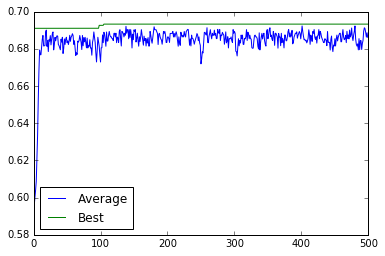

In [519]:
plt.plot(res['PopAveFitness'],label="Average")
plt.plot(res['PopBestFitness'],label="Best")
plt.legend(loc='best')

(array([ 20966.,    234.,    200.,    199.,    189.,    136.,    140.,
           144.,    163.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

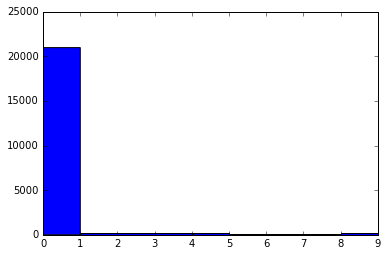

In [506]:
plt.hist(res['examples'],bins=np.arange(10))

In [509]:
exgar = ExampleSelectorGA(flatdecoys,flatactives,csarlabels,csarfeatures)
randpop = exgar.generate_random_start(100)
randres = exgar.evolve(randpop,500)


Generation: 1
---------------
Mean AUC: 0.592777762779
Best AUC: 0.597111165651
Time: 93.6518220901
Best Individual: 0.597111165651 

Generation: 2
---------------
Mean AUC: 0.594617183431
Best AUC: 0.597111165651
Time: 177.03242898
Best Individual: 0.597547483672 

Generation: 3
---------------
Mean AUC: 0.595647287329
Best AUC: 0.597547483672
Time: 263.34027791
Best Individual: 0.598408530017 

Generation: 4
---------------
Mean AUC: 0.596088821396
Best AUC: 0.598408530017
Time: 352.670501947
Best Individual: 0.598408530017 

Generation: 5
---------------
Mean AUC: 0.596462046468
Best AUC: 0.598408530017
Time: 437.235432863
Best Individual: 0.598408530017 

Generation: 6
---------------
Mean AUC: 0.596701757544
Best AUC: 0.598408530017
Time: 519.325201035
Best Individual: 0.598408530017 

Generation: 7
---------------
Mean AUC: 0.596985389482
Best AUC: 0.598408530017
Time: 603.750671864
Best Individual: 0.598415620185 

Generation: 8
---------------
Mean AUC: 0.597265951514
Best AUC

KeyboardInterrupt: 

Let's try something different:
* systematically remove every single active example
* keep track of which ones improve CSAR CV by their removal
* apply GA to just that subset
* repeat

In [521]:
firstactives = [poses[0] for poses in flatactives]

In [544]:
def evalflat(trainactives):
    aucs = []
    for dsample in flatdecoys:
        labels = []
        predictions = []
        classifier = LinearRegression()
        x = np.array(dsample+trainactives)
        y = [0 for _ in xrange(len(dsample))] + [1 for _ in xrange(len(trainactives))]
        classifier.fit(x,y)
        pred = classifier.predict(csarfeatures)
        auc = roc_auc_score(csarlabels,pred)
        aucs.append(auc)
    return np.mean(aucs)
    
def evaloneout(which):
    '''return AUC CV value if which pose is left out of actives'''
    trainactives = firstactives[:which]+firstactives[which+1:]
    return evalflat(trainactives)

In [528]:
fullval = evaloneout(300000) #doesn't remove anything
diffs = []
for i in xrange(len(firstactives)):
    val = evaloneout(i)
    diffs.append(fullval-val)
    if i % 100 == 0:
        print i,

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

Negative diff is bad because it means eliminating that pose improved score

In [530]:
dvals = np.array(diffs)

In [541]:
np.count_nonzero(dvals > 0.00001)

6327

(0, 3000)

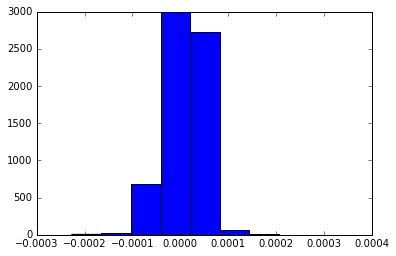

In [539]:
plt.hist(diffs)
plt.ylim(0,3000)

In [ ]:
cutoffs = sorted(diffs)[0:500:10]

In [573]:
selres = []
for i in cutoffs:
    goodsel = list(np.array(firstactives)[dvals >= i])
    selres.append( (len(goodsel),evalflat(goodsel)) )
selres = np.array(selres)

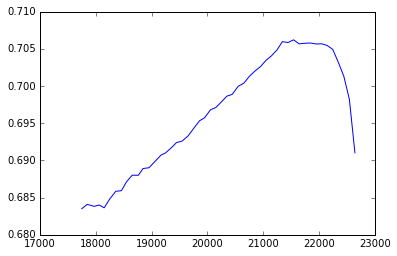

In [576]:
plt.plot(selres[:,0],selres[:,1])

In [582]:
cut = sorted(diffs)[len(firstactives)/10]

In [584]:
downsampled = []
for (val,poses) in zip(diffs,flatactives):
    if val > cut: # keep only first pose
        downsampled.append([poses[0]])
    else:
        downsampled.append(poses)

In [585]:
exgadown = ExampleSelectorGA(flatdecoys,downsampled,csarlabels,csarfeatures)
start = exgadown.generate_start(100)
downres  = exgadown.evolve(start,500)


Generation: 1
---------------
Mean AUC: 0.692812462333
Best AUC: 0.697277511896
Time: 117.30035615
Best Individual: 0.697277511896 

Generation: 2
---------------
Mean AUC: 0.694400854229
Best AUC: 0.697277511896
Time: 201.349290133
Best Individual: 0.697277511896 

Generation: 3
---------------
Mean AUC: 0.69514354113
Best AUC: 0.697277511896
Time: 287.129705191
Best Individual: 0.697277511896 

Generation: 4
---------------
Mean AUC: 0.695754393859
Best AUC: 0.697277511896
Time: 371.690650225
Best Individual: 0.697375138054 

Generation: 5
---------------
Mean AUC: 0.696299961822
Best AUC: 0.697375138054
Time: 459.451374054
Best Individual: 0.697608704545 

Generation: 6
---------------
Mean AUC: 0.696481040618
Best AUC: 0.697608704545
Time: 545.100964069
Best Individual: 0.697608704545 

Generation: 7
---------------
Mean AUC: 0.696824375861
Best AUC: 0.697608704545
Time: 631.263358116
Best Individual: 0.698149466192 

Generation: 8
---------------
Mean AUC: 0.696966550088
Best AUC

KeyboardInterrupt: 

What if we just use the model trained on the first poses to select the poses?

In [598]:
dsample = flatdecoys[0] + flatdecoys[1] + flatdecoys[2]
trainactives = firstactives
classifier = LinearRegression()
x = np.array(dsample+trainactives)
y = [0 for _ in xrange(len(dsample))] + [1 for _ in xrange(len(trainactives))]
classifier.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [605]:
p = classifier.predict(csarfeatures)
roc_auc_score(csarlabels,p)

0.6940592574412674

In [612]:
posescores = []
for poses in flatactives:
    scores = []
    for pose in poses:
        score = classifier.predict([pose])[0]
        scores.append(score)
    posescores.append(scores)

In [617]:
positions = []
for s in posescores:
    positions.append(np.argmax(s))

(array([ 9929.,  3879.,  2341.,  1550.,  1109.,   833.,   644.,   540.,
          402.,   196.,   173.,   174.,   130.,   102.,   102.,    85.,
           74.,    64.,    49.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

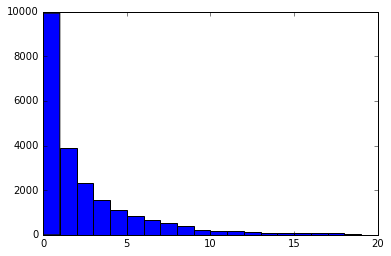

In [618]:
plt.hist(positions,bins=np.arange(0,20))

In [620]:
reselectedactives = []
for (s,poses) in zip(posescores,flatactives):
    reselectedactives.append(poses[np.argmax(s)])

In [621]:
dsample = flatdecoys[0] + flatdecoys[1] + flatdecoys[2]
trainactives = reselectedactives
classifier = LinearRegression()
x = np.array(dsample+trainactives)
y = [0 for _ in xrange(len(dsample))] + [1 for _ in xrange(len(trainactives))]
classifier.fit(x,y)
p = classifier.predict(csarfeatures)
roc_auc_score(csarlabels,p)

0.72704353635756269

In [622]:
posescores = []
for poses in flatactives:
    scores = []
    for pose in poses:
        score = classifier.predict([pose])[0]
        scores.append(score)
    posescores.append(scores)

In [623]:
positions = []
for s in posescores:
    positions.append(np.argmax(s))

(array([ 6227.,  3214.,  2491.,  1860.,  1486.,  1313.,  1059.,   997.,
          878.,   343.,   338.,   309.,   254.,   241.,   256.,   232.,
          204.,   169.,    87.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

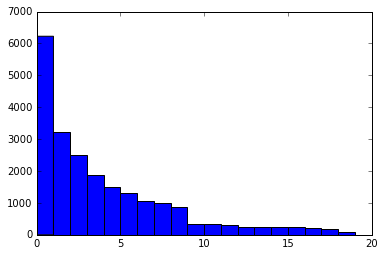

In [624]:
plt.hist(positions,bins=np.arange(0,20))

In [642]:
#let's do this iteratively
selectedindices=[]
trainingsets = []
aucs = []
trainactives = firstactives
for i in xrange(10):
    dsample = flatdecoys[0] + flatdecoys[1] + flatdecoys[2]
    classifier = LinearRegression()
    x = np.array(dsample+trainactives)
    y = [0 for _ in xrange(len(dsample))] + [1 for _ in xrange(len(trainactives))]
    classifier.fit(x,y)
    p = classifier.predict(csarfeatures)
    trainp = classifier.predict(x)
    auc = roc_auc_score(csarlabels,p)
    trainauc = roc_auc_score(y,trainp)
    aucs.append((auc,trainauc))
    trainingsets.append((auc,(x,y)))
    print i, auc,trainauc
    #use model to select poses
    selected = []
    indices = []
    for poses in flatactives:
        scores = []
        for pose in poses:
            score = classifier.predict([pose])[0]
            scores.append(score)
        sel = np.argmax(scores)
        indices.append(sel)
        selected.append(poses[sel])
    selectedindices.append(indices)
    trainactives = selected

0 0.694059257441 0.838253293468
1 0.727043536358 0.90958436544
2 0.725455747808 0.929964095373
3 0.720278561787 0.934465049724
4 0.716148539016 0.935861082387
5 0.713579034919 0.936556049422
6 0.712406430237 0.936985075434
7 0.711808538198 0.937305468908
8 0.711085204729 0.937606778121
9 0.710532307986 0.937852227566


In [629]:
logaucs = aucs
logselectedindices = selectedindices

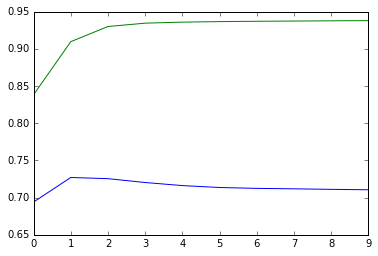

In [633]:
plt.plot(aucs)


Okay, that was better than any GA approach, let's see how it fairs with D3R.

In [635]:
hsp90features = []
hsp90names = []
for line in open('/home/dkoes/scorebench/D3R/HSP90Challenge2015final/SCOREDATA.D3R'):
    tokens = line.rstrip().split()
    target = tokens[1]
    ligname = tokens[3]    
    x = np.array(tokens[4:],np.float32)
    hsp90features.append(x)
    hsp90names.append(ligname)


In [657]:
hsp90affinities = dict()
f = open('/home/dkoes/scorebench/D3R/HSP90_AFFINITY.csv')
f.readline()
for line in f:
    tokens = line.split(',')
    hsp90affinities[tokens[0]] = -math.log(float(tokens[1]))

In [658]:
def evalsp90pred(pred):
    '''return just the best scores matched with the correct affinity from pred'''
    vals = dict()
    for (name,p) in zip(hsp90names,pred):
        if name not in vals:
            vals[name] = []
        vals[name].append(p)
    ret = []
    for name in sorted(hsp90affinities.keys()):
        ret.append( (np.max(vals[name]),hsp90affinities[name]) )
    return np.array(ret)

In [665]:
ps = []; es = []
for train in trainingsets:
    classifier = LinearRegression()
    classifier.fit(train[1][0],train[1][1])
    p0 = classifier.predict(hsp90features)
    e0 = evalsp90pred(p0)
    ps.append(p0)
    es.append(e0)
    print train[0],scipy.stats.kendalltau(e0[:,0],e0[:,1])

0.694059257441 KendalltauResult(correlation=0.21219037047077902, pvalue=2.3462502100694406e-05)
0.727043536358 KendalltauResult(correlation=0.20068607327658017, pvalue=6.3392236700200434e-05)
0.725455747808 KendalltauResult(correlation=0.17320358553488288, pvalue=0.00055630558463409731)
0.720278561787 KendalltauResult(correlation=0.16144363729192404, pvalue=0.001292296948843993)
0.716148539016 KendalltauResult(correlation=0.15492453554854468, pvalue=0.0020167490242473996)
0.713579034919 KendalltauResult(correlation=0.15147324639028503, pvalue=0.0025363729215861493)
0.712406430237 KendalltauResult(correlation=0.14789413170764537, pvalue=0.0032021617772693112)
0.711808538198 KendalltauResult(correlation=0.14418719150062576, pvalue=0.0040562752986868034)
0.711085204729 KendalltauResult(correlation=0.14035242576922613, pvalue=0.0051528106614541561)
0.710532307986 KendalltauResult(correlation=0.13984112367170617, pvalue=0.005317686755228649)


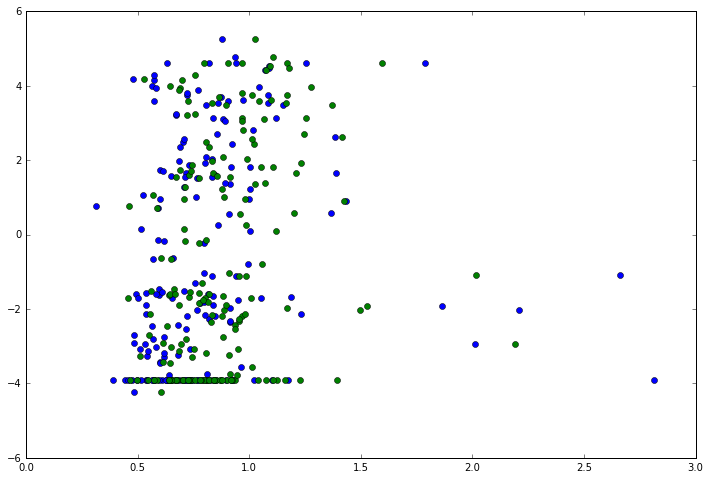

In [669]:
plt.figure(figsize=(12,8))
plt.plot(es[0][:,0],es[0][:,1],'o')
plt.plot(es[1][:,0],es[1][:,1],'o')
 

Drat, well what about throwing out the worst ones?

In [671]:
for i in cutoffs:
    goodsel = list(np.array(firstactives)[dvals >= i])
    dsample = flatdecoys[0] + flatdecoys[1] + flatdecoys[2]
    classifier = LinearRegression()
    x = np.array(dsample+goodsel)
    y = [0 for _ in xrange(len(dsample))] + [1 for _ in xrange(len(goodsel))]
    classifier.fit(x,y)
    p0 = classifier.predict(hsp90features)
    e0 = evalsp90pred(p0)
    print i,scipy.stats.kendalltau(e0[:,0],e0[:,1])

-0.000226612672312 KendalltauResult(correlation=0.21219037047077902, pvalue=2.3462502100694406e-05)
-6.96745340261e-05 KendalltauResult(correlation=0.21308514914143895, pvalue=2.1671338095562512e-05)
-5.84938847302e-05 KendalltauResult(correlation=0.21014516208069922, pvalue=2.8100174402077898e-05)
-5.27672107007e-05 KendalltauResult(correlation=0.20988951103193926, pvalue=2.8737720014528247e-05)
-4.84040304877e-05 KendalltauResult(correlation=0.21091211522697914, pvalue=2.6267238634399307e-05)
-4.56770428546e-05 KendalltauResult(correlation=0.20784430264185946, pvalue=3.4356626250318565e-05)
-4.33591033665e-05 KendalltauResult(correlation=0.20515996662987973, pvalue=4.3327043140208982e-05)
-4.1586561405e-05 KendalltauResult(correlation=0.2024756306179, pvalue=5.4490474890387521e-05)
-3.94049712985e-05 KendalltauResult(correlation=0.19953564355716027, pvalue=6.9823817992541228e-05)
-3.7632429337e-05 KendalltauResult(correlation=0.1973626096427005, pvalue=8.3691629701499571e-05)
-3.6268

In [674]:
len(np.array(firstactives)[dvals < cutoffs[1]])

100

So we can very very slightly improve HSP90 results be removing 100 worst offenders from >22000 active poses (for CSAR it's 1000).  Doing one round of re-selection produces a very tiny improvement.

Definitely not amazing.